In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('./dataset2/train.csv')
df = pd.get_dummies(df).astype('float32')
df = df.fillna(df.mean())

In [4]:
df_bureau = pd.read_csv('./dataset2/bureau.csv')
df_bureau = pd.get_dummies(df_bureau)
df_bureau_balance = pd.read_csv('./dataset2/bureau_balance.csv')
df_bureau_balance['STATUS'] = df_bureau_balance['STATUS'].apply(lambda s: 0 if s == 'C' or s == 'X' else int(s))
df_bureau_balance = df_bureau_balance.drop(columns=['MONTHS_BALANCE'])
df_bureau_balance = df_bureau_balance.groupby(['SK_ID_BUREAU'])['STATUS'].mean().reset_index()
df_bureau = df_bureau.merge(df_bureau_balance, on='SK_ID_BUREAU', how='left').fillna(0)
df_bureau = df_bureau.drop(columns=['SK_ID_BUREAU'])
df_bureau = df_bureau.groupby(['SK_ID_CURR']).mean()
df_bureau.head()

,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,STATUS
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-735.000000,0.0,82.428571,-471.714286,0.000000,0.0,207623.571429,85240.928571,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007519
100002,-874.000000,0.0,-261.750000,-523.125000,1050.643125,0.0,108131.945625,30722.625000,3998.570625,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.255682
100003,-1400.750000,0.0,-544.500000,-823.000000,0.000000,0.0,254350.125000,0.000000,202500.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
100004,-867.000000,0.0,-488.500000,-532.500000,0.000000,0.0,94518.900000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
100005,-190.666667,0.0,439.333333,-41.000000,0.000000,0.0,219042.000000,189469.500000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [5]:
df_installments = pd.read_csv('./dataset2/installments_payments.csv') \
  .drop(columns=['NUM_INSTALMENT_NUMBER']) \
  .groupby(['SK_ID_CURR', 'SK_ID_PREV']).mean().reset_index() \
  # .drop(columns=['SK_ID_PREV']) \
  # .groupby(['SK_ID_CURR']).mean().reset_index()
df_installments.head()

,SK_ID_CURR,SK_ID_PREV,NUM_INSTALMENT_VERSION,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,100001,1369693,1.250000,-1664.0,-1679.500000,7312.725000,7312.725000
1,100001,1851984,1.000000,-2886.0,-2882.333333,3981.675000,3981.675000
2,100002,1038818,1.052632,-295.0,-315.421053,11559.247105,11559.247105
3,100003,1810518,1.142857,-626.0,-630.428571,164425.332857,164425.332857
4,100003,2396755,1.000000,-2145.0,-2151.750000,6731.115000,6731.115000


In [6]:
df_pos_cash_balance = pd.read_csv('./dataset2/POS_CASH_balance.csv')
df_pos_cash_balance = pd.get_dummies(df_pos_cash_balance) \
  .drop(columns=['MONTHS_BALANCE']) \
  .groupby(['SK_ID_CURR', 'SK_ID_PREV']).mean().reset_index() \
  # .drop(columns=['SK_ID_PREV']) \
  # .groupby(['SK_ID_CURR']).mean().reset_index()
df_pos_cash_balance.head()

,SK_ID_CURR,SK_ID_PREV,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Amortized debt,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Signed,NAME_CONTRACT_STATUS_XNA
0,100001,1369693,4.000,2.000,0.00,0.00,0.800,0.0,0.0,0.0,0.200,0.0,0.0,0.0,0.0
1,100001,1851984,4.000,0.750,1.75,1.75,0.750,0.0,0.0,0.0,0.250,0.0,0.0,0.0,0.0
2,100002,1038818,24.000,15.000,0.00,0.00,1.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
3,100003,1810518,11.375,7.875,0.00,0.00,0.875,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0
4,100003,2396755,12.000,6.500,0.00,0.00,1.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0


In [7]:
df_credit_card_balance = pd.read_csv('./dataset2/credit_card_balance.csv')
df_credit_card_balance = pd.get_dummies(df_credit_card_balance) \
  .drop(columns=['MONTHS_BALANCE']) \
  .groupby(['SK_ID_CURR', 'SK_ID_PREV']).mean().reset_index() \
  .fillna(0)
  # .drop(columns=['SK_ID_PREV']) \
  # .groupby(['SK_ID_CURR']).mean().reset_index() \
df_credit_card_balance.head()

,SK_ID_CURR,SK_ID_PREV,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Sent proposal,NAME_CONTRACT_STATUS_Signed
0,100006,1489396,0.000000,270000.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,100011,1843384,54482.111149,164189.189189,2432.432432,2432.432432,0.0,0.0,3956.221849,4843.064189,...,25.767123,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,100013,2038692,18159.919219,131718.750000,6350.000000,5953.125000,0.0,0.0,1454.539551,7168.346250,...,18.719101,0.010417,0.010417,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,100021,2594025,0.000000,675000.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.411765,0.0,0.588235,0.0,0.0,0.0,0.0
4,100023,1499902,0.000000,135000.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [8]:
df_prev = pd.read_csv('./dataset2/previous_application.csv')
df_prev = pd.get_dummies(df_prev) \
  .merge(df_pos_cash_balance, on=['SK_ID_CURR', 'SK_ID_PREV'], how='left') \
  .merge(df_installments, on=['SK_ID_CURR', 'SK_ID_PREV'], how='left') \
  .merge(df_credit_card_balance, on=['SK_ID_CURR', 'SK_ID_PREV'], how='left') \
  .fillna(0) \
  .drop(columns=['SK_ID_PREV']) \
  .groupby(['SK_ID_CURR']).mean().reset_index()
df_prev.head()

,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,...,CNT_INSTALMENT_MATURE_CUM,SK_DPD_y,SK_DPD_DEF_y,NAME_CONTRACT_STATUS_Active_y,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Completed_y,NAME_CONTRACT_STATUS_Demand_y,NAME_CONTRACT_STATUS_Refused_y,NAME_CONTRACT_STATUS_Sent proposal,NAME_CONTRACT_STATUS_Signed_y
0,100001,3951.000,24835.50,23787.00,2520.0,24835.50,13.000000,1.0,0.104326,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100002,9251.775,179055.00,179055.00,0.0,179055.00,9.000000,1.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100003,56553.990,435436.50,484191.00,2295.0,435436.50,14.666667,1.0,0.033354,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100004,5357.250,24282.00,20106.00,4860.0,24282.00,5.000000,1.0,0.212008,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100005,2406.600,22308.75,20076.75,2232.0,22308.75,10.500000,1.0,0.054482,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df = df.merge(df_prev, on='SK_ID_CURR', how='left').fillna(0)
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CNT_INSTALMENT_MATURE_CUM,SK_DPD_y,SK_DPD_DEF_y,NAME_CONTRACT_STATUS_Active_y,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Completed_y,NAME_CONTRACT_STATUS_Demand_y,NAME_CONTRACT_STATUS_Refused_y,NAME_CONTRACT_STATUS_Sent proposal,NAME_CONTRACT_STATUS_Signed_y
0,100002.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,100003.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,100004.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,100006.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,...,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0
4,100007.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
X = df.drop('TARGET', 1)
y = df[['TARGET']]

/var/folders/4z/lbz63ss95h15yxn82nk2z4f80000gn/T/ipykernel_96248/2361704643.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df.drop('TARGET', 1)


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [344] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


                              features  ANOVA_f_values
29                        EXT_SOURCE_2     8110.506247
30                        EXT_SOURCE_3     7811.655210
28                        EXT_SOURCE_1     3053.204477
7                           DAYS_BIRTH     1893.976087
304     NAME_CONTRACT_STATUS_Refused_x     1877.185302
..                                 ...             ...
319         NAME_TYPE_SUITE_Children_y       70.108946
162     OCCUPATION_TYPE_Security staff       65.998029
303    NAME_CONTRACT_STATUS_Canceled_x       65.882893
365           NAME_PRODUCT_TYPE_x-sell       60.465545
377  NAME_SELLER_INDUSTRY_Construction       60.366780

[160 rows x 2 columns]


/var/folders/4z/lbz63ss95h15yxn82nk2z4f80000gn/T/ipykernel_96248/323001207.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar.set_xticklabels(bar.get_xticklabels(), rotation=90);


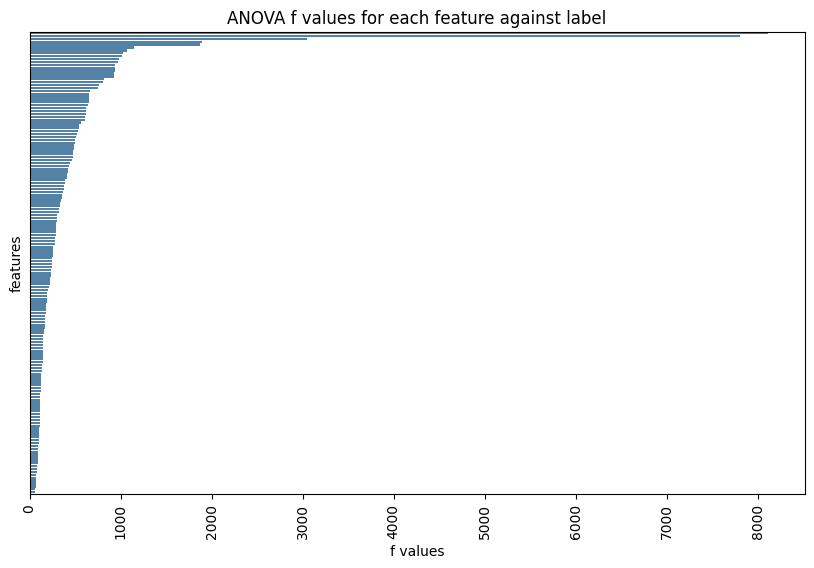

In [11]:
from sklearn.feature_selection import f_classif
import seaborn as sns

scores = f_classif(X, y['TARGET'])   #performing ANOVA for the features against the target

df_scores = pd.DataFrame({'features': X.columns.to_list(), 'ANOVA_f_values': scores[0]}).sort_values(by=['ANOVA_f_values'], ascending=False)
df_scores = df_scores.head(160)
print(df_scores)
plt.figure(figsize=(10,6))
bar = sns.barplot(y='features', x='ANOVA_f_values', data=df_scores, color='steelblue')
bar.set_xticklabels(bar.get_xticklabels(), rotation=90);
bar.set_yticks([])
bar.set_yticklabels([])
bar.set_xlabel('f values');
bar.set_title('ANOVA f values for each feature against label');

In [12]:
df[df_scores.features].head()

,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,DAYS_BIRTH,NAME_CONTRACT_STATUS_Refused_x,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,NAME_PRODUCT_TYPE_walk-in,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,...,CNT_INSTALMENT,AMT_APPLICATION,AMT_GOODS_PRICE_y,DAYS_LAST_DUE_1ST_VERSION,NAME_CONTRACT_STATUS_Active_y,NAME_TYPE_SUITE_Children_y,OCCUPATION_TYPE_Security staff,NAME_CONTRACT_STATUS_Canceled_x,NAME_PRODUCT_TYPE_x-sell,NAME_SELLER_INDUSTRY_Construction
0,0.262949,0.139376,0.083037,-9461.0,0.000000,2.0,2.0,0.000000,1.0,0.0,...,24.000000,179055.00,179055.00,125.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
1,0.622246,0.510853,0.311267,-16765.0,0.000000,1.0,1.0,0.000000,0.0,1.0,...,9.791667,435436.50,435436.50,-1004.333333,0.000000,0.0,0.0,0.000000,0.333333,0.000000
2,0.555912,0.729567,0.502130,-19046.0,0.000000,2.0,2.0,0.000000,1.0,0.0,...,3.750000,24282.00,24282.00,-694.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3,0.650442,0.510853,0.502130,-19005.0,0.111111,2.0,2.0,0.000000,1.0,0.0,...,4.296296,272203.26,272203.26,40704.000000,0.111111,0.0,0.0,0.333333,0.444444,0.111111
4,0.322738,0.510853,0.502130,-19932.0,0.000000,2.0,2.0,0.166667,1.0,0.0,...,12.555556,150530.25,150530.25,-697.666667,0.000000,0.0,0.0,0.000000,0.500000,0.000000


Text(0.5, 1.03, 'Highest correlation features')

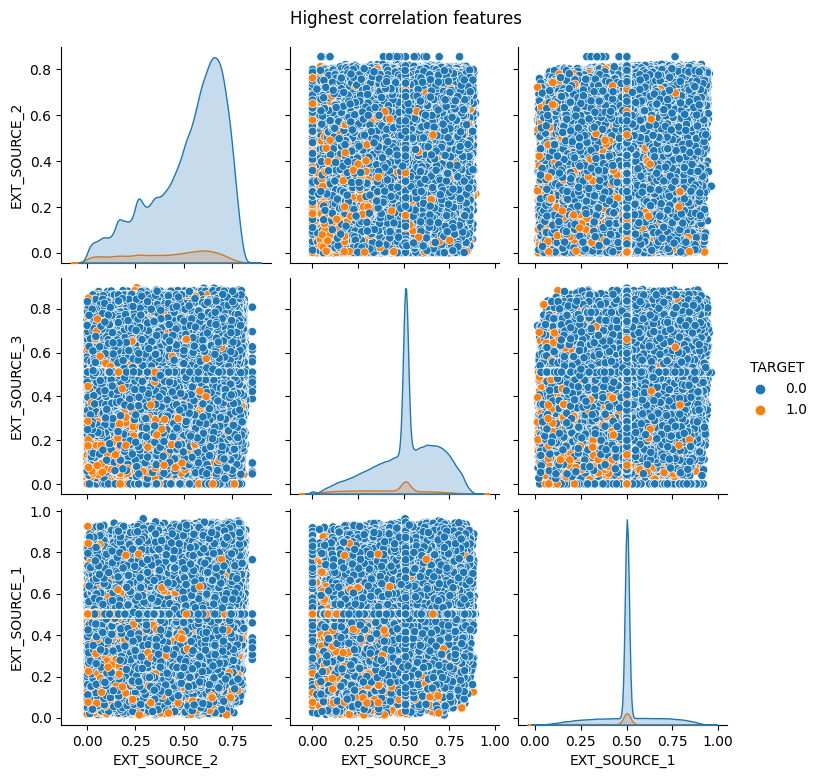

In [13]:
low_f = df[['EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_1', 'TARGET']]
# for col in low_f.columns.to_list()[:-1]:
#     low_f = low_f[
#         (low_f[col] < np.quantile(low_f[col], 0.975)) &
#         (low_f[col] > np.quantile(low_f[col], .025))]

g = sns.pairplot(low_f, hue='TARGET')
g.fig.suptitle('Highest correlation features', y=1.03)


Text(0.5, 1.03, 'Highest correlation features')

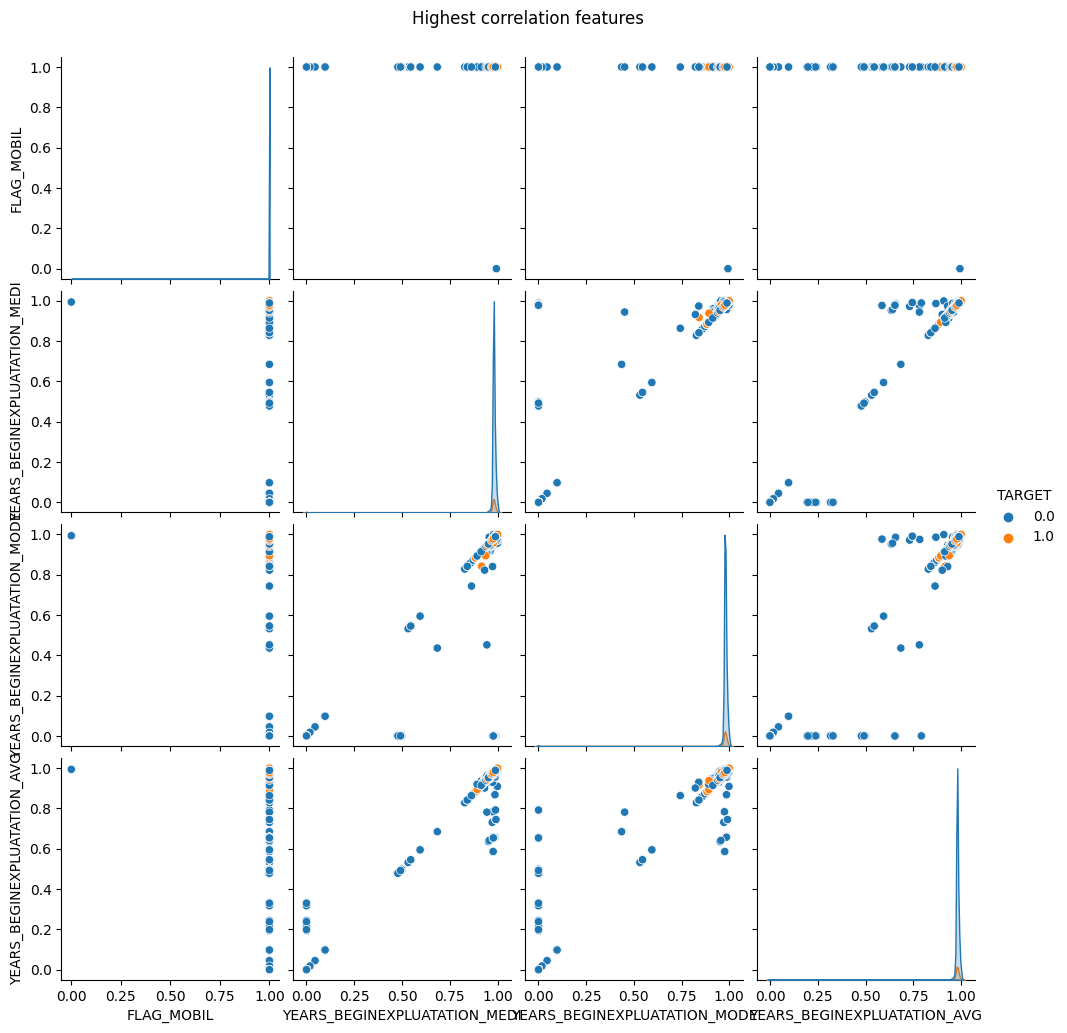

In [14]:
low_f = df[['FLAG_MOBIL', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'TARGET']]
# for col in low_f.columns.to_list()[:-1]:
#     low_f = low_f[
#         (low_f[col] < np.quantile(low_f[col], 0.975)) &
#         (low_f[col] > np.quantile(low_f[col], .025))]

g = sns.pairplot(low_f, hue='TARGET')
g.fig.suptitle('Highest correlation features', y=1.03)


In [2]:
df = pd.read_csv('./dataset2/train.csv')
df = pd.get_dummies(df).astype('float32')
df = df.fillna(df.mean())

In [3]:
df_bureau = pd.read_csv('./dataset2/bureau.csv')
df_bureau = pd.get_dummies(df_bureau)
df_bureau_balance = pd.read_csv('./dataset2/bureau_balance.csv')
df_bureau_balance['STATUS'] = df_bureau_balance['STATUS'].apply(lambda s: 0 if s == 'C' or s == 'X' else int(s))
df_bureau_balance = df_bureau_balance.groupby(['SK_ID_BUREAU']).apply(lambda x: list(x.nlargest(12, ['MONTHS_BALANCE'])['STATUS'])).reset_index(name='STATUS_TS')
df_bureau_balance

,SK_ID_BUREAU,STATUS_TS
0,5001709,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,5001710,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,5001711,"[0, 0, 0, 0]"
3,5001712,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,5001713,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...
817390,6842884,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
817391,6842885,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]"
817392,6842886,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
817393,6842887,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [4]:
def pad_and_reverse(ls, n=12, p=-1):
  return np.array(list(reversed((ls + [p] * (n - len(ls))))))

df_bureau_balance['STATUS_TS'] = df_bureau_balance['STATUS_TS'].apply(pad_and_reverse)
df_bureau_balance

,SK_ID_BUREAU,STATUS_TS
0,5001709,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,5001710,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,5001711,"[-1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0]"
3,5001712,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,5001713,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...
817390,6842884,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
817391,6842885,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]"
817392,6842886,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
817393,6842887,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [5]:
df_bureau = df_bureau.merge(df_bureau_balance, on='SK_ID_BUREAU', how='left')
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,STATUS_TS
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,...,0,0,0,0,0,0,0,0,0,NaN
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,...,0,0,0,0,0,0,0,0,0,NaN
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,...,0,0,0,0,0,0,0,0,0,NaN
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,...,0,0,0,0,0,0,0,0,0,NaN
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,...,0,0,0,0,0,0,0,0,0,NaN


In [6]:
# df_bureau = df_bureau.fillna(0)
for i, column in enumerate(df_bureau.columns):
  if column != 'STATUS_TS':
    print(f'column {i}: {column}')
    df_bureau[column] = df_bureau[column].fillna(0)

df_bureau = df_bureau.drop(columns=['SK_ID_BUREAU'])
df_bureau = df_bureau.groupby(['SK_ID_CURR'])

column 0: SK_ID_CURR
column 1: SK_ID_BUREAU
column 2: DAYS_CREDIT
column 3: CREDIT_DAY_OVERDUE
column 4: DAYS_CREDIT_ENDDATE
column 5: DAYS_ENDDATE_FACT
column 6: AMT_CREDIT_MAX_OVERDUE
column 7: CNT_CREDIT_PROLONG
column 8: AMT_CREDIT_SUM
column 9: AMT_CREDIT_SUM_DEBT
column 10: AMT_CREDIT_SUM_LIMIT
column 11: AMT_CREDIT_SUM_OVERDUE
column 12: DAYS_CREDIT_UPDATE
column 13: AMT_ANNUITY
column 14: CREDIT_ACTIVE_Active
column 15: CREDIT_ACTIVE_Bad debt
column 16: CREDIT_ACTIVE_Closed
column 17: CREDIT_ACTIVE_Sold
column 18: CREDIT_CURRENCY_currency 1
column 19: CREDIT_CURRENCY_currency 2
column 20: CREDIT_CURRENCY_currency 3
column 21: CREDIT_CURRENCY_currency 4
column 22: CREDIT_TYPE_Another type of loan
column 23: CREDIT_TYPE_Car loan
column 24: CREDIT_TYPE_Cash loan (non-earmarked)
column 25: CREDIT_TYPE_Consumer credit
column 26: CREDIT_TYPE_Credit card
column 27: CREDIT_TYPE_Interbank credit
column 28: CREDIT_TYPE_Loan for business development
column 29: CREDIT_TYPE_Loan for purchas

In [7]:
def remove_none_and_stack(shape, fill):
  def helper(arr):
    _arr = [a for a in arr if isinstance(a, np.ndarray)]
    if _arr:
      if len(_arr) > 4:
        return np.stack(_arr[:4])
      else:
        return np.concatenate((_arr, np.full((4 - len(_arr), *shape), fill)))
    else:
      return np.full((4, *shape), fill)
  return helper

tss = df_bureau['STATUS_TS'].agg(remove_none_and_stack((12,), -1))
df_bureau = df_bureau.mean()
df_bureau['STATUS_TSS'] = tss
df_bureau.head()

/var/folders/4z/lbz63ss95h15yxn82nk2z4f80000gn/T/ipykernel_18626/2505860250.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_bureau = df_bureau.mean()


,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,STATUS_TSS
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-735.000000,0.0,82.428571,-471.714286,0.000000,0.0,207623.571429,85240.928571,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, ..."
100002,-874.000000,0.0,-261.750000,-523.125000,1050.643125,0.0,108131.945625,30722.625000,3998.570625,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, ..."
100003,-1400.750000,0.0,-544.500000,-823.000000,0.000000,0.0,254350.125000,0.000000,202500.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ..."
100004,-867.000000,0.0,-488.500000,-532.500000,0.000000,0.0,94518.900000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ..."
100005,-190.666667,0.0,439.333333,-41.000000,0.000000,0.0,219042.000000,189469.500000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1, -1..."


In [8]:
# df_installments = pd.read_csv('./dataset2/installments_payments.csv')
def pad2d_and_reverse(arr, n=4, p=0):
  return np.flip(np.concatenate((arr, np.full((n - arr.shape[0], arr.shape[1]), p)), 0), 0)

df_installments = pd.read_csv('./dataset2/installments_payments.csv') \
  .fillna(0) \
  .groupby(['SK_ID_CURR', 'SK_ID_PREV']) \
  .apply(lambda x: pad2d_and_reverse(x.nlargest(4, ['NUM_INSTALMENT_NUMBER'])[2:].to_numpy())) \
  .reset_index(name='INSTALLMENT_TS')
df_installments.head()

,SK_ID_CURR,SK_ID_PREV,INSTALLMENT_TS
0,100001,1369693,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...."
1,100001,1851984,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...."
2,100002,1038818,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...."
3,100003,1810518,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...."
4,100003,2396755,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...."


In [9]:
df_pos_cash_balance = pd.read_csv('./dataset2/POS_CASH_balance.csv')
df_pos_cash_balance = pd.get_dummies(df_pos_cash_balance) \
  .fillna(0) \
  .groupby(['SK_ID_CURR', 'SK_ID_PREV']) \
  .apply(lambda x: pad2d_and_reverse(x.nlargest(4, ['MONTHS_BALANCE'])[2:].to_numpy())) \
  .reset_index(name='POS_CASH_TS')
df_pos_cash_balance.head()

,SK_ID_CURR,SK_ID_PREV,POS_CASH_TS
0,100001,1369693,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,100001,1851984,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,100002,1038818,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,100003,1810518,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,100003,2396755,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [10]:
df_pos_cash_balance['POS_CASH_TS'][0].shape

(4, 16)

In [11]:
df_credit_card_balance = pd.read_csv('./dataset2/credit_card_balance.csv')
df_credit_card_balance = pd.get_dummies(df_credit_card_balance) \
  .fillna(0) \
  .groupby(['SK_ID_CURR', 'SK_ID_PREV']) \
  .apply(lambda x: pad2d_and_reverse(x.nlargest(4, ['MONTHS_BALANCE'])[2:].to_numpy())) \
  .reset_index(name='CREDIT_CARD_BALANCE_TS')
df_credit_card_balance.head()

,SK_ID_CURR,SK_ID_PREV,CREDIT_CARD_BALANCE_TS
0,100006,1489396,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,100011,1843384,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,100013,2038692,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,100021,2594025,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,100023,1499902,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [12]:
df_prev = pd.read_csv('./dataset2/previous_application.csv')
df_prev = pd.get_dummies(df_prev) \
  .merge(df_pos_cash_balance, on=['SK_ID_CURR', 'SK_ID_PREV'], how='left') \
  .merge(df_installments, on=['SK_ID_CURR', 'SK_ID_PREV'], how='left') \
  .merge(df_credit_card_balance, on=['SK_ID_CURR', 'SK_ID_PREV'], how='left') \

for i, column in enumerate(df_prev.columns):
  if column not in {'INSTALLMENT_TS', 'POS_CASH_TS', 'CREDIT_CARD_BALANCE_TS'}:
    print(f'column {i}: {column}')
    df_prev[column] = df_prev[column].fillna(0)

# df_prev = df_prev.fillna(0)
df_prev.head()

column 0: SK_ID_PREV
column 1: SK_ID_CURR
column 2: AMT_ANNUITY
column 3: AMT_APPLICATION
column 4: AMT_CREDIT
column 5: AMT_DOWN_PAYMENT
column 6: AMT_GOODS_PRICE
column 7: HOUR_APPR_PROCESS_START
column 8: NFLAG_LAST_APPL_IN_DAY
column 9: RATE_DOWN_PAYMENT
column 10: RATE_INTEREST_PRIMARY
column 11: RATE_INTEREST_PRIVILEGED
column 12: DAYS_DECISION
column 13: SELLERPLACE_AREA
column 14: CNT_PAYMENT
column 15: DAYS_FIRST_DRAWING
column 16: DAYS_FIRST_DUE
column 17: DAYS_LAST_DUE_1ST_VERSION
column 18: DAYS_LAST_DUE
column 19: DAYS_TERMINATION
column 20: NFLAG_INSURED_ON_APPROVAL
column 21: NAME_CONTRACT_TYPE_Cash loans
column 22: NAME_CONTRACT_TYPE_Consumer loans
column 23: NAME_CONTRACT_TYPE_Revolving loans
column 24: NAME_CONTRACT_TYPE_XNA
column 25: WEEKDAY_APPR_PROCESS_START_FRIDAY
column 26: WEEKDAY_APPR_PROCESS_START_MONDAY
column 27: WEEKDAY_APPR_PROCESS_START_SATURDAY
column 28: WEEKDAY_APPR_PROCESS_START_SUNDAY
column 29: WEEKDAY_APPR_PROCESS_START_THURSDAY
column 30: WEEKDAY

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,POS_CASH_TS,INSTALLMENT_TS,CREDIT_CARD_BALANCE_TS
0,2030495,271877,1730.430,17145.0,17145.0,0.0,17145.0,15,1,0.0,...,0,0,0,1,0,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....",NaN
1,2802425,108129,25188.615,607500.0,679671.0,0.0,607500.0,11,1,0.0,...,0,0,0,0,0,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....",NaN
2,2523466,122040,15060.735,112500.0,136444.5,0.0,112500.0,11,1,0.0,...,0,0,0,0,0,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....",NaN
3,2819243,176158,47041.335,450000.0,470790.0,0.0,450000.0,7,1,0.0,...,0,0,0,0,0,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....",NaN
4,1784265,202054,31924.395,337500.0,404055.0,0.0,337500.0,9,1,0.0,...,0,0,0,0,0,0,0,NaN,NaN,NaN


In [13]:
df_prev = df_prev.groupby(['SK_ID_CURR'])
ts1 = df_prev['INSTALLMENT_TS'].agg(remove_none_and_stack((4, 8), 0))
ts2 = df_prev['POS_CASH_TS'].agg(remove_none_and_stack((4, 16), 0))
ts3 = df_prev['CREDIT_CARD_BALANCE_TS'].agg(remove_none_and_stack((4, 29), 0))
df_prev = df_prev.mean()
df_prev['INSTALLMENT_TSS'] = ts1
df_prev['POS_CASH_TSS'] = ts2
df_prev['CREDIT_CARD_BALANCE_TSS'] = ts3
df_prev.reset_index()
df_prev.head()

/var/folders/4z/lbz63ss95h15yxn82nk2z4f80000gn/T/ipykernel_18626/3084707198.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_prev = df_prev.mean()
/var/folders/4z/lbz63ss95h15yxn82nk2z4f80000gn/T/ipykernel_18626/3084707198.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_prev['INSTALLMENT_TSS'] = ts1
/var/folders/4z/lbz63ss95h15yxn82nk2z4f80000gn/T/ipykernel_18626/3084707198.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at

,SK_ID_PREV,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,...,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,INSTALLMENT_TSS,POS_CASH_TSS,CREDIT_CARD_BALANCE_TSS
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1.369693e+06,3951.000,24835.50,23787.00,2520.0,24835.50,13.000000,1.0,0.104326,0.0,...,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
100002,1.038818e+06,9251.775,179055.00,179055.00,0.0,179055.00,9.000000,1.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
100003,2.281150e+06,56553.990,435436.50,484191.00,2295.0,435436.50,14.666667,1.0,0.033354,0.0,...,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
100004,1.564014e+06,5357.250,24282.00,20106.00,4860.0,24282.00,5.000000,1.0,0.212008,0.0,...,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
100005,2.176837e+06,2406.600,22308.75,20076.75,2232.0,22308.75,10.500000,1.0,0.054482,0.0,...,0.0,0.000000,0.0,0.5,0.0,0.0,0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


In [14]:
df = df \
  .merge(df_prev, on='SK_ID_CURR', how='left') \
  .merge(df_bureau, on='SK_ID_CURR', how='left')

In [15]:
def fill_empty(shape, fill):
  def helper(x):
    return x if isinstance(x, np.ndarray) else np.full(shape, fill)
  return helper

df['STATUS_TSS'] = df['STATUS_TSS'].apply(fill_empty((4, 12), -1))
df['INSTALLMENT_TSS'] = df['INSTALLMENT_TSS'].apply(fill_empty((4, 4, 8), 0))
df['POS_CASH_TSS'] = df['POS_CASH_TSS'].apply(fill_empty((4, 4, 16), 0))
df['CREDIT_CARD_BALANCE_TSS'] = df['CREDIT_CARD_BALANCE_TSS'].apply(fill_empty((4, 4, 29), 0))
df = df.fillna(0)
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,STATUS_TSS
0,100002.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, ..."
1,100003.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ..."
2,100004.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ..."
3,100006.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ..."
4,100007.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ..."


In [16]:
ts1 = df['STATUS_TSS']
ts2 = df['INSTALLMENT_TSS']
ts3 = df['POS_CASH_TSS']
ts4 = df['CREDIT_CARD_BALANCE_TSS']
df = df.drop(columns=['STATUS_TSS', 'INSTALLMENT_TSS', 'POS_CASH_TSS', 'CREDIT_CARD_BALANCE_TSS'])

In [17]:
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,100002.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
from sklearn.feature_selection import f_classif

X = df.drop(columns=['SK_ID_CURR', 'TARGET'])
y = df[['TARGET']]

scores = f_classif(X, y['TARGET'])

df_scores = pd.DataFrame({'features': X.columns.to_list(), 'ANOVA_f_values': scores[0]}).sort_values(by=['ANOVA_f_values'], ascending=False)
df_scores = df_scores.head(100)
df_imp = df[df_scores.features]

X = df_imp.astype('float32')
X = (X - X.mean()) / X.std()
X.head()

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [344] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,DAYS_CREDIT,DAYS_BIRTH,NAME_CONTRACT_STATUS_Refused,DAYS_ENDDATE_FACT,CREDIT_ACTIVE_Closed,DAYS_CREDIT_UPDATE,REGION_RATING_CLIENT_W_CITY,...,FLAG_PHONE,PRODUCT_COMBINATION_POS mobile with interest,NAME_INCOME_TYPE_State servant,NAME_CASH_LOAN_PURPOSE_Repairs,NAME_CONTRACT_TYPE_Consumer loans,AMT_CREDIT_SUM,FONDKAPREMONT_MODE_reg oper account,NAME_FAMILY_STATUS_Civil marriage,TOTALAREA_MODE,FLAG_OWN_CAR_N
0,-1.317461,-2.129246e+00,-3.006513,0.083760,1.506877,-0.579686,-0.048392,0.712846,-0.068226,-0.062698,...,1.599334,-0.593357,-0.275564,-0.159575,1.222381,-0.258182,1.779076,-0.327423,-1.133972e+00,0.717912
1,0.565105,-3.416440e-07,-1.369221,-0.733140,-0.166821,-0.579686,-0.658313,0.712846,-0.753087,-2.051810,...,1.599334,-0.593357,3.628913,-0.159575,0.310406,-0.083266,1.779076,-0.327423,-4.029754e-01,0.717912
2,0.217545,1.253631e+00,0.000000,0.094616,-0.689508,-0.579686,-0.067460,1.424668,-0.137823,-0.062698,...,1.599334,-0.593357,-0.275564,-0.159575,1.222381,-0.274466,-0.562088,-0.327423,-1.927911e-07,-1.392923
3,0.712840,-3.416440e-07,0.000000,1.439185,-0.680113,0.033928,1.015601,-1.422618,1.014715,-0.062698,...,-0.625258,-0.593357,-0.275564,-0.159575,-0.905562,-0.387536,-0.562088,3.054144,-1.927911e-07,0.717912
4,-1.004188,-3.416440e-07,0.000000,-0.342719,-0.892533,-0.579686,-0.576957,1.424668,-0.681595,-0.062698,...,-0.625258,0.026050,-0.275564,-0.159575,-0.601570,-0.212582,-0.562088,-0.327423,-1.927911e-07,0.717912


In [19]:
# ts1_norm = (ts1 - ts1.mean())
# ts1_norm = (ts1 - ts1.mean()) / ts1.std()
# ts1_norm
X = torch.tensor(X.values).float()
y = torch.tensor(y.values).float()
ts1_tensor = torch.tensor(ts1.to_list())[:, :, :, None].float()
ts2_tensor = torch.tensor(ts2.to_list()).float()
ts3_tensor = torch.tensor(ts3.to_list()).float()
ts4_tensor = torch.tensor(ts4.to_list()).float()

/var/folders/4z/lbz63ss95h15yxn82nk2z4f80000gn/T/ipykernel_18626/3969363408.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  ts1_tensor = torch.tensor(ts1.to_list())[:, :, :, None].float()


In [30]:
torch.save(X, './dataset2/nts.pt')
torch.save(y, './dataset2/y.pt')
torch.save(ts1_tensor, './dataset2/ts1.pt')
torch.save(ts2_tensor, './dataset2/ts2.pt')
torch.save(ts3_tensor, './dataset2/ts3.pt')
torch.save(ts4_tensor, './dataset2/ts4.pt')

In [23]:
from sklearn.model_selection import StratifiedKFold, KFold

skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)
g = skf.split(X, y)
_, train_index = next(g)
_, test_index = next(g)
X_train = X[train_index]
y_train = y[train_index]
ts1_train = ts1_tensor[train_index]
ts2_train = ts2_tensor[train_index]
ts3_train = ts3_tensor[train_index]
ts4_train = ts4_tensor[train_index]
X_test = X[test_index]
y_test = y[test_index]
ts1_test = ts1_tensor[test_index]
ts2_test = ts2_tensor[test_index]
ts3_test = ts3_tensor[test_index]
ts4_test = ts4_tensor[test_index]

In [24]:
print(ts1_train.shape)
print(ts2_train.shape)
print(ts3_train.shape)
print(ts4_train.shape)
print(ts1_train.dtype)
print(y_train.dtype)
print(torch.isnan(ts1_train).any())
print(torch.isnan(ts2_train).any())
print(torch.isnan(ts3_train).any())
print(torch.isnan(ts4_train).any())

torch.Size([30752, 4, 12, 1])
torch.Size([30752, 4, 4, 8])
torch.Size([30752, 4, 4, 16])
torch.Size([30752, 4, 4, 29])
torch.float32
torch.float32
tensor(False)
tensor(False)
tensor(False)
tensor(False)
